In [1]:
from Simulator import *

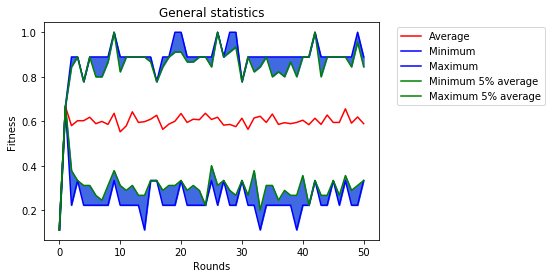

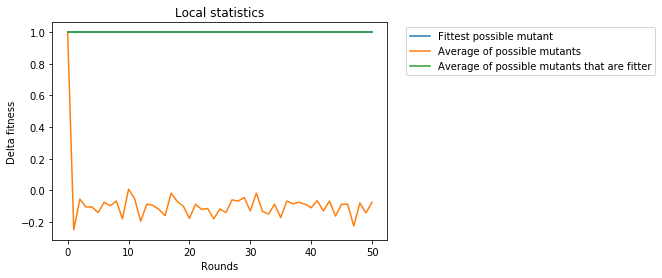

In [2]:
initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = 0.5
rounds = 50
orgNum = 100
clause1 = Clause([1],1)
clause2 = Clause([2],1)
clause3 = Clause([3],1)
clause4 = Clause([4],1)
clause5 = Clause([5],1)
clause6 = Clause([6],1)
clause7 = Clause([7],1)
clause8 = Clause([8],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

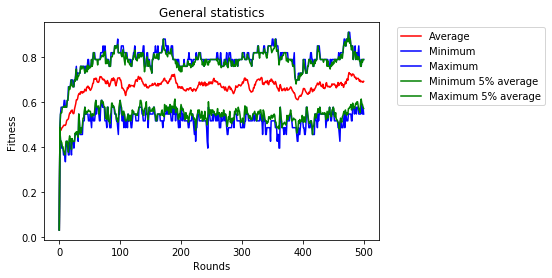

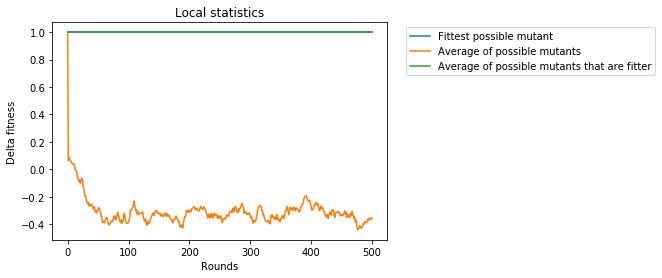

In [30]:
initial = [0] * 32
probability = 0.01
rounds = 500
orgNum = 100
clause1 = Clause([1],1)
clause2 = Clause([2],1)
clause3 = Clause([3],1)
clause4 = Clause([4],1)
clause5 = Clause([5],1)
clause6 = Clause([6],1)
clause7 = Clause([7],1)
clause8 = Clause([8],1)
clause9 = Clause([9],1)
clause10 = Clause([10],1)
clause11 = Clause([11],1)
clause12 = Clause([12],1)
clause13 = Clause([13],1)
clause14 = Clause([14],1)
clause15 = Clause([15],1)
clause16 = Clause([16],1)
clause17 = Clause([17],1)
clause18 = Clause([18],1)
clause19 = Clause([19],1)
clause20 = Clause([20],1)
clause21 = Clause([21],1)
clause22 = Clause([22],1)
clause23 = Clause([23],1)
clause24 = Clause([24],1)
clause25 = Clause([25],1)
clause26 = Clause([26],1)
clause27 = Clause([27],1)
clause28 = Clause([28],1)
clause29 = Clause([29],1)
clause30 = Clause([30],1)
clause31 = Clause([31],1)
clause32 = Clause([32],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8, clause9, clause10, clause11, clause12, clause13, clause14, clause15, clause16, clause17, clause18, clause19, clause20, clause21, clause22, clause23, clause24, clause25, clause26, clause27, clause28, clause29, clause30, clause31, clause32]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()

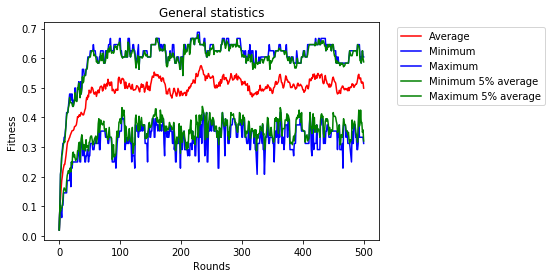

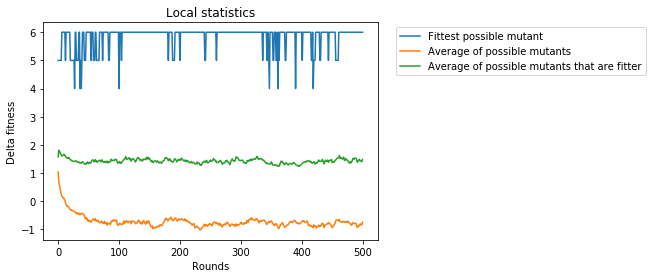

In [31]:
initial = [0] * 32
probability = 0.01
rounds = 500
orgNum = 100
clause1 = Clause([1,5,7],1)
clause2 = Clause([2,1,3],2)
clause3 = Clause([-3,5,7],1)
clause4 = Clause([4,2],1)
clause5 = Clause([-5,3],2)
clause6 = Clause([-6,18],1)
clause7 = Clause([7,23],1)
clause8 = Clause([8,-19],3)
clause9 = Clause([9,-1],1)
clause10 = Clause([10,-6],1)
clause11 = Clause([11,-12,-22],2)
clause12 = Clause([12,11],1)
clause13 = Clause([13,14],1)
clause14 = Clause([14,-1],5)
clause15 = Clause([15,-29],1)
clause16 = Clause([16,32],1)
clause17 = Clause([17,-31],1)
clause18 = Clause([18,5],1)
clause19 = Clause([19,4],1)
clause20 = Clause([20,17],3)
clause21 = Clause([21,-7],1)
clause22 = Clause([22,-2],1)
clause23 = Clause([-23,4],1)
clause24 = Clause([24,-7],1)
clause25 = Clause([25,-6],1)
clause26 = Clause([26,-2],1)
clause27 = Clause([27],2)
clause28 = Clause([28],1)
clause29 = Clause([29],3)
clause30 = Clause([30],1)
clause31 = Clause([31],2)
clause32 = Clause([32],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8, clause9, clause10, clause11, clause12, clause13, clause14, clause15, clause16, clause17, clause18, clause19, clause20, clause21, clause22, clause23, clause24, clause25, clause26, clause27, clause28, clause29, clause30, clause31, clause32]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()

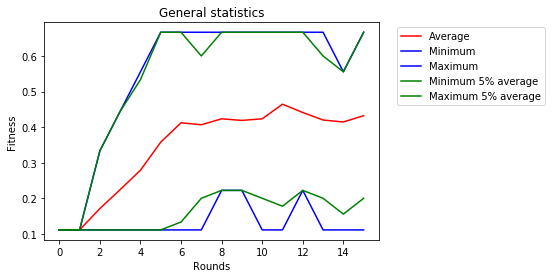

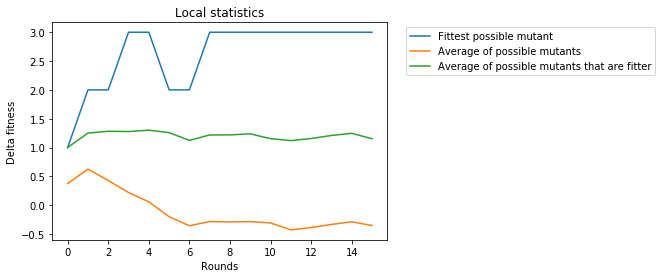

In [32]:
initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = 0.05
rounds = 15
orgNum = 100
clause1 = Clause([1,2,3],1)
clause2 = Clause([5,-4,7],1)
clause3 = Clause([6,7],1)
clause4 = Clause([1,-2],1)
clause5 = Clause([5,8],1)
clause6 = Clause([6,-8],1)
clause7 = Clause([7,-3],1)
clause8 = Clause([8,3],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]

mySim = Simulator(initial, probability, rounds, orgNum, clauses)
mySim.run()

In [ ]:
#Observations:
#    Under this model, they tend to converge to an optimum quite fast
    
#What to do:
#    How to select the children / try various methods
#    For local statistics, how to plot the individuals
#    Use joyplots

[3]
